## Point Registration

This tutorial shows you how to register 'nii' files with points. The points can be computed by segmentations like in Verse19.

You can get the Verse19 data from:

https://osf.io/nqjyw/

We assume in this tutorial that you copied the "dataset-verse19validation" folder next to this file.


In [5]:
from pathlib import Path
from BIDS.registration.ridged_points.reg_segmentation import ridged_from_points, resample
from BIDS import Centroids, NII
from BIDS.snapshot2D import Snapshot_Frame, create_snapshot
from IPython.display import Image


loading data

In [25]:
ct1 = Path("pointbased_registation/dataset-verse19validation/rawdata/sub-verse018/sub-verse018_ct.nii.gz").absolute()
ct2 = Path("pointbased_registation/dataset-verse19validation/rawdata/sub-verse026/sub-verse026_ct.nii.gz").absolute()


def to_vert(p: Path):
    return Path(str(p).replace("rawdata", "derivatives").replace("_ct.nii.gz", "_seg-vert_msk.nii.gz"))


def to_poi(p: Path):
    return Path(str(p).replace("rawdata", "derivatives").replace("_ct.nii.gz", "_seg-vb_ctd.json"))


c1_vert = to_vert(ct1)
c2_vert = to_vert(ct2)
c1_poi = to_poi(ct1)
c2_poi = to_poi(ct2)
print(ct1.exists(), ct1)

False /DATA/robert/bids/../../pointbased_registation/dataset-verse19validation/rawdata/sub-verse018/sub-verse018_ct.nii.gz


### From Centroid or Points of Interest(POI) list

We load the POIs form the json. It should have the following shape:
```[
    {
        "direction": ["P","I","R"]
    },
    {
        "label": 20, "X": 91.1,"Y": 40.0, "Z": 95.0
    },
    {
        "label": 21, "X": 76.5,"Y": 68.1, "Z": 90.3
    },
    {
        "label": 22, "X": 63.6,"Y": 101.2, "Z": 86.3
    },
    {
        "label": 23, "X": 59.0,"Y": 136.8, "Z": 86.8
    },
    {
        "label": 24, "X": 72.1,"Y": 166.6, "Z": 94.0
    }
]
```

where the coordinate are the local cords of the image

In [7]:
# Given centroid file in local space an nii we can register two images
resampler, resampler_seg, transform = ridged_from_points(
    Centroids().load(c1_poi), Centroids().load(c2_poi), representative_fixed=ct1, representative_movig=ct2
)
assert resampler is not None
assert resampler_seg is not None
rep_moving_nii: NII = resample(resampler, resampler_seg, moving_img=ct2)
rep_seg_moving_nii: NII = resample(resampler, resampler_seg, moving_img=c2_vert, is_seg=True)
ct1_frame = Snapshot_Frame(ct1, segmentation=c1_vert, centroids=c1_poi, mode="CT")
ct2_frame = Snapshot_Frame(rep_moving_nii, segmentation=rep_seg_moving_nii, centroids=c1_poi, mode="CT")
create_snapshot("test.jpg", [ct1_frame, ct2_frame])
Image(filename="test.jpg")


FileNotFoundError: [Errno 2] No such file or directory: '/media/data/robert/code/pointbased_registation/dataset-verse19validation/derivatives/sub-verse018/sub-verse018_seg-vb_ctd.json'

The moved images has some space unoccupied. We can remove non corresponding spaces by cropping

[ ] 'set_array' with different dtype: from float32 to uint8
[ ] 'set_array' with different dtype: from float32 to uint8


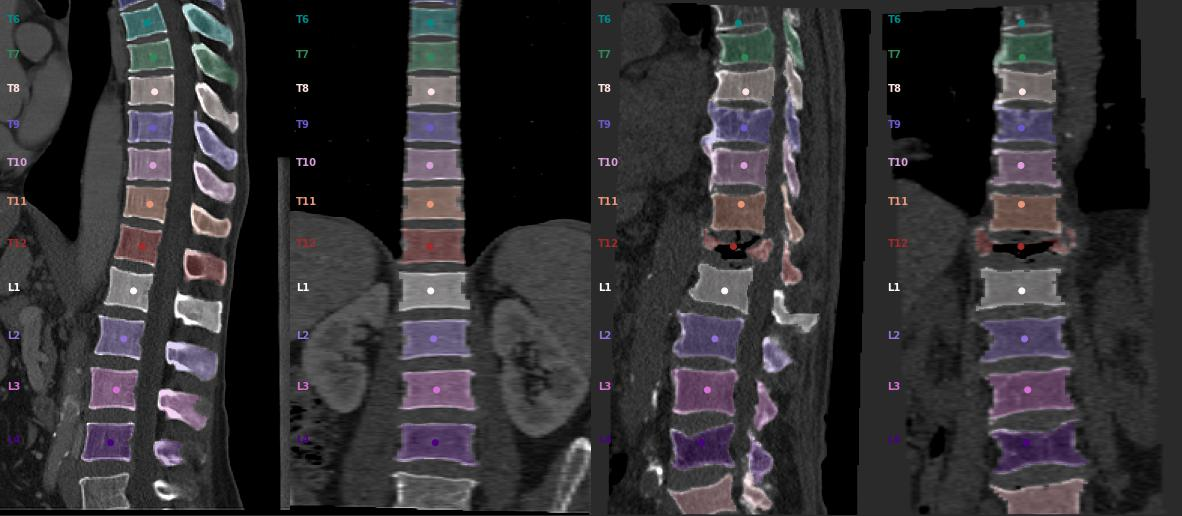

In [16]:
from BIDS import to_nii, NII

# NII is a wrapper around nibabel
ct1_nii = to_nii(ct1).copy()
ct2_nii = rep_moving_nii.copy()
ct1_seg = to_nii(c1_vert, seg=True)
ct2_seg = rep_seg_moving_nii.copy()

ex_slice_f = ct1_nii.compute_crop_slice()
shared_pixels = ct2_nii.compute_crop_slice(other_crop=ex_slice_f)


c1_poi_cropped = Centroids().load(c1_poi).shift_all_centroid_coordinates(shared_pixels)
ct1_nii.apply_crop_slice_(shared_pixels)
ct2_nii.apply_crop_slice_(shared_pixels)
ct1_seg.apply_crop_slice_(shared_pixels)
ct2_seg.apply_crop_slice_(shared_pixels)

ct1_frame = Snapshot_Frame(ct1_nii, segmentation=ct1_seg, centroids=c1_poi_cropped, mode="CT")
ct2_frame = Snapshot_Frame(ct2_nii, segmentation=ct2_seg, centroids=c1_poi_cropped, mode="CT")
create_snapshot("test.jpg", [ct1_frame, ct2_frame])
Image(filename="test.jpg")


## Computing Centroids from segmentation

We can generate Centroids/POI by computing the Center Of Mass of Segmentation.

Variant 1: Just using the segmentation

In [5]:
from BIDS import calc_centroids

ctd = calc_centroids(c1_vert, decimals=0)
print(to_nii(c1_vert))
print("orientation", ctd.orientation)
print("shape", ctd.shape)
print("zoom", ctd.zoom)
print("points", ctd.keys())
print("id 9", ctd[9])
print("\n", ctd)


shp=(401, 522, 100); ori=('P', 'I', 'R'), zoom=(1.0, 1.0, 2.9999998), seg=False
orientation ('P', 'I', 'R')
shape (401, 522, 100)
zoom (1.0, 1.0, 2.999999761581421)
points dict_keys([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
id 9 (234.0, 76.0, 49.0)

 Centroids(orientation=('P', 'I', 'R'), centroids={8: (221.0, 58.0, 48.0), 9: (234.0, 76.0, 49.0), 10: (246.0, 95.0, 50.0), 11: (257.0, 116.0, 50.0), 12: (266.0, 138.0, 51.0), 13: (274.0, 161.0, 51.0), 14: (278.0, 186.0, 51.0), 15: (278.0, 210.0, 51.0), 16: (277.0, 235.0, 51.0), 17: (276.0, 261.0, 51.0), 18: (273.0, 288.0, 51.0), 19: (269.0, 317.0, 51.0), 20: (263.0, 347.0, 51.0), 21: (257.0, 378.0, 50.0), 22: (251.0, 411.0, 50.0), 23: (246.0, 446.0, 50.0)}, location=<Location.Unknown: 0>, zoom=(1.0, 1.0, 2.999999761581421), info={})


Variant 2: Segmentation and Subregion Segmentation

If you have two files, where the second splits the other in smaller chunks you can use this variant. (Verse does not provide this...)

In [6]:
vert_nii = to_nii(c1_vert, seg=True)
arr = vert_nii.get_array()
arr[arr != 0] = 50
subregion_nii = vert_nii.set_array(arr, inplace=False)
from BIDS import calc_centroids_from_subreg_vert

ctd = calc_centroids_from_subreg_vert(vert_nii, subregion_nii, subreg_id=[50])
print(ctd)
print(list(ctd.items2()))
print("Note: the ids are subregion_ID*256 + segmentation id. Matching points MUST have the same ID")


[ ] 'set_array' with different dtype: from uint8 to uint16
Centroids(orientation=('P', 'I', 'R'), centroids={12808: (221.1, 58.3, 48.5), 12809: (234.4, 75.6, 49.0), 12810: (246.2, 95.0, 49.8), 12811: (257.0, 115.7, 50.3), 12812: (266.3, 137.7, 50.7), 12813: (273.6, 160.9, 50.8), 12814: (278.0, 185.6, 50.7), 12815: (278.3, 210.4, 50.6), 12816: (277.5, 235.4, 50.7), 12817: (275.9, 260.7, 50.9), 12818: (273.2, 287.6, 50.9), 12819: (268.7, 316.8, 50.6), 12820: (263.3, 346.5, 50.8), 12821: (256.6, 378.0, 50.1), 12822: (250.7, 411.4, 49.8), 12823: (246.0, 446.0, 50.0)}, location=<Location.Multi: 256>, zoom=(1.0, 1.0, 2.999999761581421), info={})
[(50, 8, (221.1, 58.3, 48.5)), (50, 9, (234.4, 75.6, 49.0)), (50, 10, (246.2, 95.0, 49.8)), (50, 11, (257.0, 115.7, 50.3)), (50, 12, (266.3, 137.7, 50.7)), (50, 13, (273.6, 160.9, 50.8)), (50, 14, (278.0, 185.6, 50.7)), (50, 15, (278.3, 210.4, 50.6)), (50, 16, (277.5, 235.4, 50.7)), (50, 17, (275.9, 260.7, 50.9)), (50, 18, (273.2, 287.6, 50.9)), (50,

Let's use a function that does all at once and use the Vertebra center and the mask centers.

[ ] 'set_array' with different dtype: from uint8 to uint16
dict_keys([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 1000, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023])
[ ] 'set_array' with different dtype: from uint8 to uint16
dict_keys([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 1000, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024])
[*] Register to shp=(401, 522, 100); ori=('P', 'I', 'R'), zoom=(1.0, 1.0, 2.9999998), seg=False
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 1000, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]
('P', 'I', 'R')
(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)
[*] used centroids: [  14   15   16   17   18   19   20   21   22   23 1000 1014 1015 1016
 1017 1018 1019 1020 1021 1022 1023]
[*] key|fixed points           |moved points after     |moved points before    |delta fixed/moved      |distF|distM|
[*] 14 |

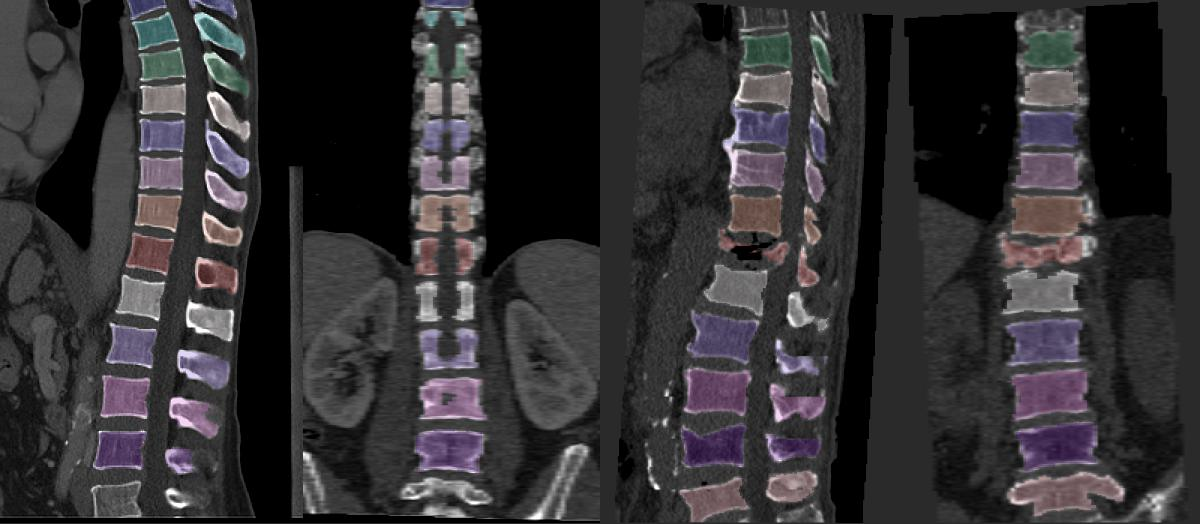

In [15]:
from BIDS.registration.ridged_points.reg_segmentation import ridged_registration_cdt

poi1 = Centroids().load(to_poi(ct1))
poi1_2 = calc_centroids(to_nii(c1_vert, True) + 1000)
for k, v in poi1_2.items():
    poi1[k] = v
print(poi1.keys())

poi2 = Centroids().load(to_poi(ct2))
poi2_2 = calc_centroids(to_nii(c2_vert, True) + 1000)
for k, v in poi2_2.items():
    poi2[k] = v
print(poi2.keys())
fixed, moving = ridged_registration_cdt(
    ctd_fixed=poi1,
    ctd_movig=poi2,
    list_fixed=[to_nii(ct1, False), to_nii(c1_vert, True)],
    list_moving=[to_nii(ct2, False), to_nii(c2_vert, True)],
)

ct1_frame = Snapshot_Frame(fixed[0], segmentation=fixed[1], mode="CT")
ct2_frame = Snapshot_Frame(moving[0], segmentation=moving[1], mode="CT")
create_snapshot("test.jpg", [ct1_frame, ct2_frame])
Image(filename="test.jpg")

You should see that the lower vertebras have their spinous process visible.

[ ] 'set_array' with different dtype: from float32 to uint8
[ ] 'set_array' with different dtype: from float32 to uint8
[ ] 'set_array' with different dtype: from float32 to uint8


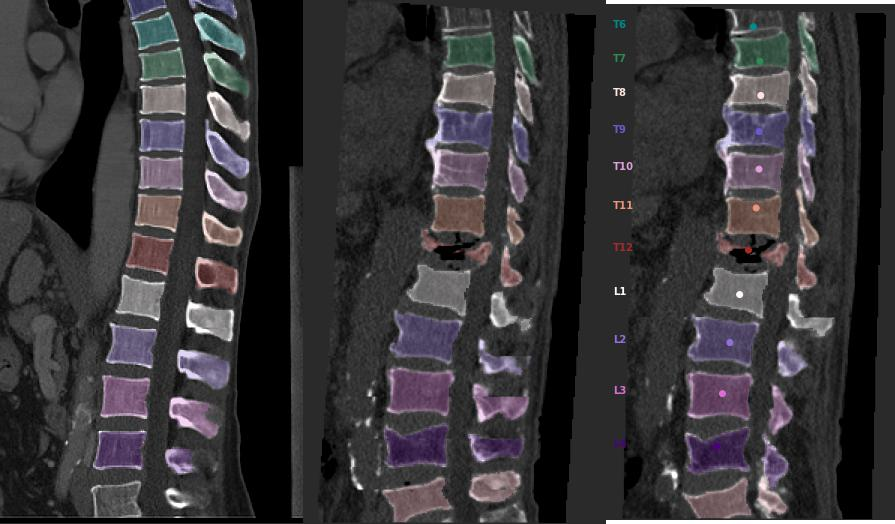

In [19]:
ct1_frame = Snapshot_Frame(fixed[0], segmentation=fixed[1], mode="CT")
ct2_frame = Snapshot_Frame(moving[0], segmentation=moving[1], mode="CT")
ct2_frame_single = Snapshot_Frame(ct2_nii, segmentation=ct2_seg, centroids=c1_poi_cropped, mode="CT")
create_snapshot("test.jpg", [ct1_frame, ct2_frame, ct2_frame_single])
Image(filename="test.jpg")
